In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import masterClass as C
import sys
import pandas as pd
import itertools
import reshape
from statistics import mean
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scipy.io
#import results
import warnings
warnings.filterwarnings("ignore")
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/')
dataDir = thisDir + 'data/corrmats/'
outDir = thisDir + 'output/results/'
figsDir=thisDir + 'output/figures/'
IndNetDir=thisDir+'data/IndNet/'
# Subjects and tasks
taskList=['glass','semantic', 'motor','mem']
#omitting MSC06 for classify All
#subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC07','MSC10']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
DSvars=list(itertools.product(list(subsComb),list(taskList)))
splitDict=dict([('MSC01',10),('MSC02',10),('MSC03',8),('MSC04',10),('MSC05',10),('MSC06',9),('MSC07',9),('MSC10',10)])
taskDict=dict([('mem',0),('motor',1),('glass',2),('semantic',3)])

def folds_MC(train_sub, clf, memFC,semFC,glassFC,motFC, restFC, testFC,ytest):
    """
    Cross validation to train and test using nested loops

    Parameters
    -----------
    clf : obj
        Machine learning algorithm
    taskFC, restFC, test_taskFC, test_restFC : array_like
        Input arrays, training and testing set of task and rest FC
    Returns
    -----------
    total_score : float
        Average accuracy across folds
    acc_score : list
        List of accuracy for each outer fold
    """

    loo = LeaveOneOut()
    yrest=np.zeros(restFC.shape[0])
    ymem=np.ones(memFC.shape[0])
    ysem=np.full(semFC.shape[0],2)
    yglass=np.full(glassFC.shape[0],3)
    ymot=np.full(motFC.shape[0],4)
    CVTacc=[]
    DSTacc=[]
    count=0
    #fold each training set
    session=splitDict[train_sub[0]]
    split=np.empty((session, 55278))
    sameF1=np.empty((session,5))
    diffF1=np.empty((session,5))
    same_sub_CM=np.zeros((5,5))
    diff_sub_CM=np.empty((session,5,5))
    diff_count=0
    for train_index, test_index in loo.split(split):
        memtrain, memval=memFC[train_index], memFC[test_index]
        ymemtrain, ymemval=ymem[train_index], ymem[test_index]
        semtrain, semval=semFC[train_index], semFC[test_index]
        ysemtrain, ysemval=ysem[train_index],ysem[test_index]
        mottrain, motval=motFC[train_index], motFC[test_index]
        ymottrain, ymotval=ymot[train_index],ymot[test_index]
        glatrain, glaval=glassFC[train_index], glassFC[test_index]
        yglatrain,yglaval=yglass[train_index],yglass[test_index]
        resttrain, restval=restFC[train_index], restFC[test_index]
        yresttrain, yrestval=yrest[train_index],yrest[test_index]
        Xtrain=np.concatenate((resttrain,memtrain,semtrain,mottrain,glatrain))
        ytrain=np.concatenate((yresttrain,ymemtrain,ysemtrain,ymottrain,yglatrain))
        yval=np.concatenate((yrestval,ymemval,ysemval,ymotval,yglaval))
        Xval=np.concatenate((restval,memval,semval,motval,glaval))
        clf.fit(Xtrain,ytrain)
        score=clf.score(Xval, yval)
        CVTacc.append(score)
        y_predict=clf.predict(Xval)
        score_same = f1_score(yval, y_predict, average=None)
        cm_same = confusion_matrix(yval, y_predict)
        same_sub_CM=same_sub_CM+cm_same
        #order is position rest, mem, sem, mot, glass
        sameF1[count]=score_same
        scoreT=clf.score(testFC,ytest)
        DSTacc.append(scoreT)
        y_pre=clf.predict(testFC)
        score_diff = f1_score(ytest, y_pre, average=None)
        cm_diff = confusion_matrix(ytest, y_pre)
        diff_sub_CM[diff_count]=cm_diff
        diff_count=diff_count+1
        #order is position rest, mem, sem, mot, glass
        diffF1[count]=score_diff
        count=count+1
    same_f=sameF1.mean(axis=0)
    same_Tsub=mean(CVTacc)
    diff_Tsub=mean(DSTacc)
    diff_f=diffF1.mean(axis=0)
    DS_cm=diff_sub_CM.mean(axis=0,dtype=int)
    return same_Tsub,diff_Tsub,same_f, diff_f, same_sub_CM, DS_cm

ImportError: cannot import name 'ConfusionMatrixDisplay' from 'sklearn.metrics' (/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [5]:
clf=RidgeClassifier()
all_CM_DS=np.zeros((5,5))
all_CM_CV=np.zeros((5,5))

#train sub
master_df=pd.DataFrame()
data=np.array(['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10'],dtype='<U61')
loo = LeaveOneOut()
for  test, train in loo.split(data): #train on one sub test on the rest
    CV_tmp=pd.DataFrame()
    DS_tmp=pd.DataFrame()
    train_sub=data[train]
    test_sub=data[test]
    memFC=reshape.matFiles(dataDir+'mem/'+train_sub[0]+'_parcel_corrmat.mat')
    semFC=reshape.matFiles(dataDir+'semantic/'+train_sub[0]+'_parcel_corrmat.mat')
    glassFC=reshape.matFiles(dataDir+'glass/'+train_sub[0]+'_parcel_corrmat.mat')
    motFC=reshape.matFiles(dataDir+'motor/'+train_sub[0]+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub[0]+'_parcel_corrmat.mat') #keep tasks seperated in order to collect the right amount of days
    testFC,ytest=C.AllSubFiles(test_sub)
    same_Tsub, diff_Tsub,sameF,diffF,same_sub_CM, DS_cm=folds_MC(train_sub, clf, memFC,semFC,glassFC,motFC, restFC, testFC, ytest)
    DS=DS_cm / DS_cm.astype(np.float).sum(axis=1)
    CV=same_sub_CM / same_sub_CM.astype(np.float).sum(axis=1)
    all_CM_DS=DS_cm+all_CM_DS
    all_CM_CV=same_sub_CM+all_CM_CV
finalDS=all_CM_DS / all_CM_DS.astype(np.float).sum(axis=1)
finalCV=all_CM_CV / all_CM_CV.astype(np.float).sum(axis=1)

In [1]:
#all packages and dataframes
import numpy as np
#import classification
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.patches as patches
%matplotlib inline 
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
taskList=['mem','glass','semantic','motor']
modelList=['Log','Ridge','SVM']
netList=['unassign','default', 'visual','fp','dan','van','salience','co','sm','sm-lat', 'auditory','pmn','pon']
feature=[14808,10824,8736, 4620,5264,3151, 484, 4060, 2375,316, 564,45,21]
netRoi=dict([('unassign',14808),('default', 10824),('visual',8736),('fp', 4620),('dan',5264),('van',3151),('salience', 484),('co', 4060),('sm', 2375),('sm-lat', 316),('auditory', 564),('pmn',45),('pon',21)])
thisDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/output/results/')
homeDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/')
figsDir = os.path.expanduser('~/Desktop/Porteretal_taskprediction/output/figures/')
sys.path.append(homeDir+'code/pyScripts/Predictions')
import reshape
Parcel_params = reshape.loadParcelParams('Gordon333')
#MSC Palette
MSCList=['1','2','3','4','5','6','7','10']
MSC_colors=np.array([[0, 0, 0],[0.9, 0.9, 0],[0, 1, 0],[1, 0, 0],[0, 0, 1],[0.2, 1, 1],[1, 0, 1],[1, 0.5, 0]])
MSCdict=dict(zip(MSCList, [mcolors.to_rgba(m) for m in MSC_colors]))
mcolors.get_named_colors_mapping().update(MSCdict)
MC=pd.read_csv(thisDir+'Ridge/ALL_MC/acc.csv',usecols=['train','acc','Analysis'])
MC.drop_duplicates(inplace=True)

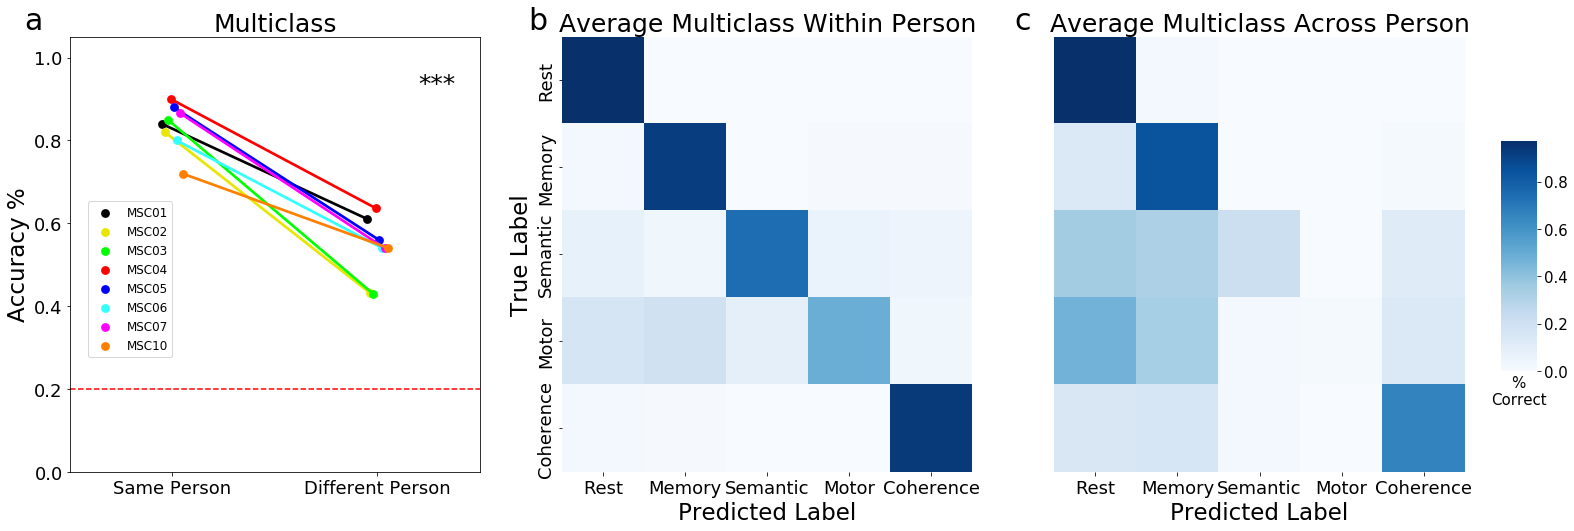

In [83]:



fig = plt.figure(figsize=(25,8),constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios = [1,1,1])
fig.text(.1, .893, 'a',fontsize=30)
fig.text(.38, .893, 'b',fontsize=30)
fig.text(.65, .893, 'c',fontsize=30)
ax0=fig.add_subplot(gs[0,0])
ax=sns.pointplot(x="Analysis",y="acc", hue="train",ci=None, data=MC, dodge=.1, ax = ax0, 
                 order=['Same Person','Different Person'], color='r', palette=['1','2','3','4','5','6','7','10'])
plt.text(1.2, .92, '***',fontsize=25)
ax.set_title('Multiclass', fontsize=25)
plt.ylabel("Accuracy %", fontsize=23)
ax.axhline(.2,color='red',linestyle='--')
plt.legend(loc='lower left',fontsize='large',bbox_to_anchor=(.03, .25))
plt.xlabel(' ')
ax.set(ylim=(0, 1.05))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax1=fig.add_subplot(gs[0,1])
sns.heatmap(finalCV, cmap="Blues",xticklabels=["Rest","Memory","Semantic","Motor", "Coherence"], yticklabels=["Rest","Memory","Semantic","Motor", "Coherence"], cbar = False, ax = ax1)
plt.ylabel('True Label',fontsize=23)
plt.xlabel('Predicted Label',fontsize=23)
plt.title('Average Multiclass Within Person',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax2=fig.add_subplot(gs[0,2])
cbar_ax = fig.add_axes([.92, .3, .02, .4])
g=sns.heatmap(finalDS, cmap="Blues",xticklabels=["Rest","Memory","Semantic","Motor", "Coherence"],cbar_ax=cbar_ax, yticklabels=["Rest","Memory","Semantic","Motor", "Coherence"], ax = ax2)
g.set_ylabel(' ')
g.set_xlabel('Predicted Label',fontsize=23)
g.set_title('Average Multiclass Across Person',fontsize=25)
g.set_yticks([],[])
g.tick_params('x',labelsize=18)
plt.xlabel('%\nCorrect', fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(figsDir+'MC_confusion.png', bbox_inches='tight')


In [49]:
MC.head()

,train,acc,Analysis
0,MSC01,0.840000,Same Person
5,MSC01,0.610435,Different Person
10,MSC02,0.820000,Same Person
15,MSC02,0.431594,Different Person
20,MSC03,0.850000,Same Person


In [ ]:
fig=plt.figure(figsize=(15,10), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 1 rows by 3 columns
gs = gridspec.GridSpec(nrows=2, ncols=2)
ax0=fig.add_subplot(gs[1,0])
sns.heatmap(finalCV, cmap="Blues",xticklabels=["Rest","Memory","Semantic","Motor", "Coherence"], yticklabels=["Rest","Memory","Semantic","Motor", "Coherence"])
plt.ylabel('True Label',fontsize=25)
plt.xlabel('Predicted Label',fontsize=25)
plt.title('Average Multiclass Within Person',fontsize=25)
plt.xticks(fontsize=17)
plt.yticks(fontsize=20)
ax1=fig.add_subplot(gs[1,1])
ax=ConfusionMatrixDisplay(finalDS,display_labels=["Rest","Memory","Semantic","Motor", "Coherence"]).plot(cmap=plt.cm.Blues,ax=ax1,colorbar=False)
plt.ylabel(' ',fontsize=25)
plt.xlabel('Predicted Label',fontsize=25)
plt.title('Average Multiclass Across Person',fontsize=25)
plt.yticks([],[])
plt.xticks(fontsize=17)


#plt.savefig(figsDir+'ALL_MC_average.png', bbox_inches='tight')

In [10]:
import sklearn.metrics 
sklearn.metrics.ConfusionMatrixDisplay

AttributeError: module 'sklearn.metrics' has no attribute 'ConfusionMatrixDisplay'

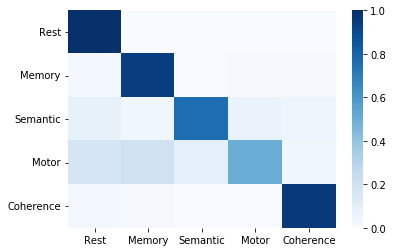

In [16]:
sns.heatmap(finalCV, cmap="Blues",xticklabels=["Rest","Memory","Semantic","Motor", "Coherence"], yticklabels=["Rest","Memory","Semantic","Motor", "Coherence"])